# FarmTech Solutions - Análise de Rendimento de Safras

**Autor:** Gabriel Marcolino, Luan Brant  
**Projeto:** Fase 5 - Machine Learning e Computação em Nuvem  
**Data:** Setembro 2024

## Descrição do Projeto

Este projeto analisa dados de condições de solo e temperatura relacionados com diferentes tipos de culturas agrícolas para prever o rendimento de safras. Utilizamos técnicas de Machine Learning supervisionado e não supervisionado para identificar padrões e criar modelos preditivos.

### Objetivos:
1. **Análise Exploratória:** Familiarização com os dados e identificação de padrões
2. **Clusterização:** Identificação de tendências e cenários discrepantes (outliers)
3. **Modelagem Preditiva:** Desenvolvimento de 5 modelos diferentes para predição de rendimento
4. **Avaliação:** Comparação dos modelos usando métricas apropriadas

### Dataset:
- **Fonte:** crop_yield.csv
- **Registros:** 157 observações
- **Culturas:** Cocoa beans, Oil palm fruit, Rice paddy, Rubber natural
- **Variáveis independentes:** Precipitação, Umidade específica, Umidade relativa, Temperatura
- **Variável dependente:** Rendimento (toneladas por hectare)

## 1. Importação de Bibliotecas e Carregamento dos Dados

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


In [22]:
df = pd.read_csv('crop_yield.csv')

print("📊 Dataset carregado com sucesso!")
print(f"Dimensões: {df.shape}")
print("\nPrimeiras 5 linhas:")
df.head()

📊 Dataset carregado com sucesso!
Dimensões: (156, 6)

Primeiras 5 linhas:


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## 2. Análise Exploratória de Dados

Nesta seção, vamos explorar o dataset para entender a distribuição dos dados, identificar padrões e relações entre as variáveis.

In [23]:
print("📋 Informações Gerais do Dataset:")
print("=" * 50)
print("Número de registros: {len(df)}")
print("Número de colunas: {len(df.columns)}")
print("\nTipos de dados:")
print(df.dtypes)
print("\nValores ausentes:")
print(df.isnull().sum())
print("\nCulturas presentes:")
print(df['Crop'].value_counts())

📋 Informações Gerais do Dataset:
Número de registros: 156
Número de colunas: 6

Tipos de dados:
Crop                                     object
Precipitation (mm day-1)                float64
Specific Humidity at 2 Meters (g/kg)    float64
Relative Humidity at 2 Meters (%)       float64
Temperature at 2 Meters (C)             float64
Yield                                     int64
dtype: object

Valores ausentes:
Crop                                    0
Precipitation (mm day-1)                0
Specific Humidity at 2 Meters (g/kg)    0
Relative Humidity at 2 Meters (%)       0
Temperature at 2 Meters (C)             0
Yield                                   0
dtype: int64

Culturas presentes:
Crop
Cocoa, beans       39
Oil palm fruit     39
Rice, paddy        39
Rubber, natural    39
Name: count, dtype: int64


In [24]:
print("📊 Estatísticas Descritivas:")
print("=" * 50)
df.describe()

📊 Estatísticas Descritivas:


,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


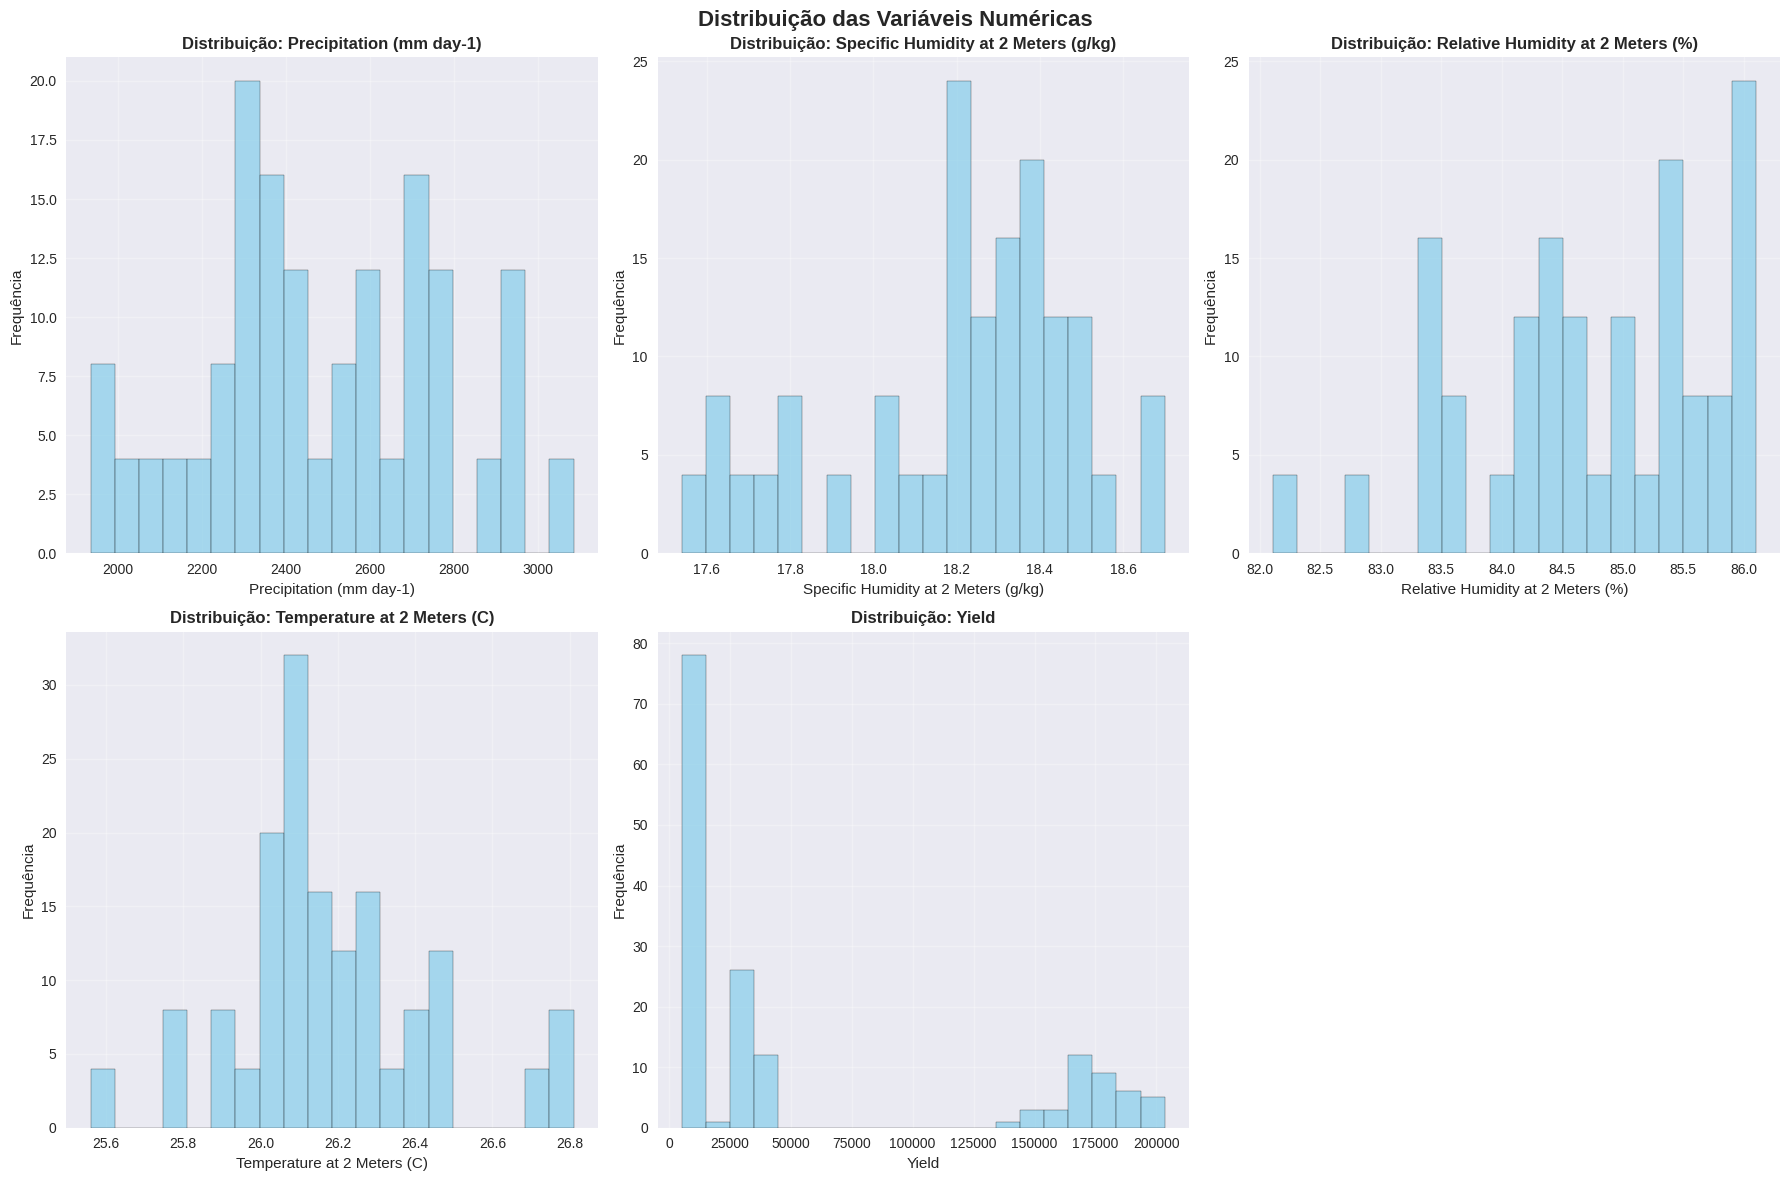

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=16, fontweight='bold')

numerical_cols = ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 
                  'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)', 'Yield']

for i, col in enumerate(numerical_cols):
    row = i // 3
    col_idx = i % 3
    
    axes[row, col_idx].hist(df[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col_idx].set_title(f'Distribuição: {col}', fontweight='bold')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequência')
    axes[row, col_idx].grid(True, alpha=0.3)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

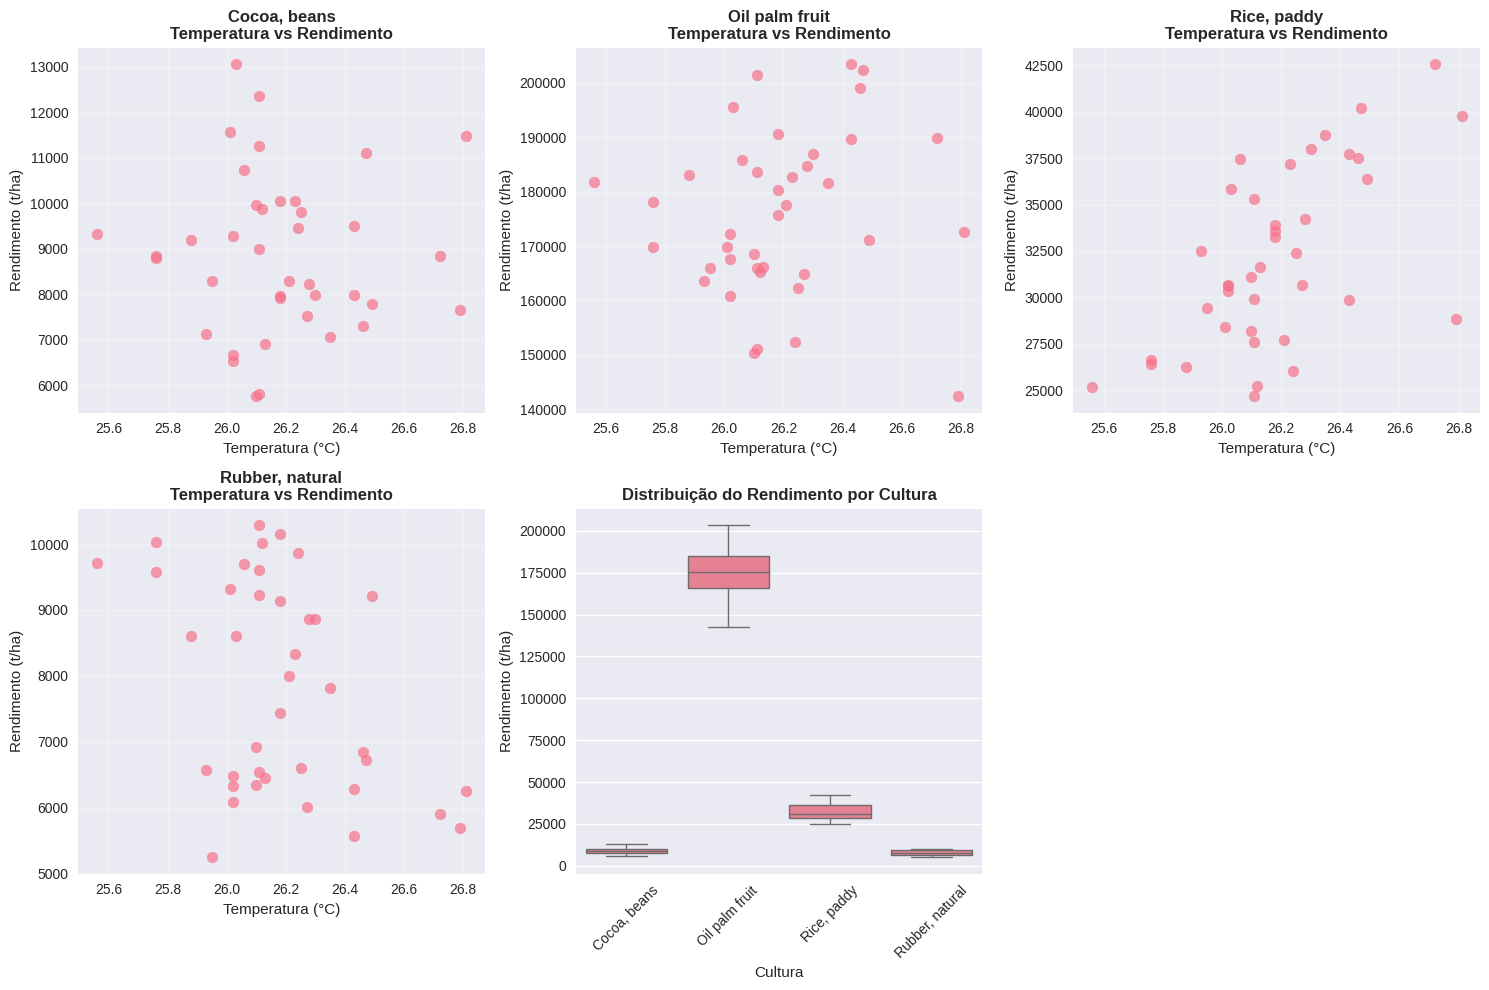

In [26]:
plt.figure(figsize=(15, 10))

for i, crop in enumerate(df['Crop'].unique()):
    plt.subplot(2, 3, i+1)
    crop_data = df[df['Crop'] == crop]
    plt.scatter(crop_data['Temperature at 2 Meters (C)'], crop_data['Yield'], 
               alpha=0.7, s=60)
    plt.title(f'{crop}\nTemperatura vs Rendimento', fontweight='bold')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Rendimento (t/ha)')
    plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='Crop', y='Yield')
plt.title('Distribuição do Rendimento por Cultura', fontweight='bold')
plt.xlabel('Cultura')
plt.ylabel('Rendimento (t/ha)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

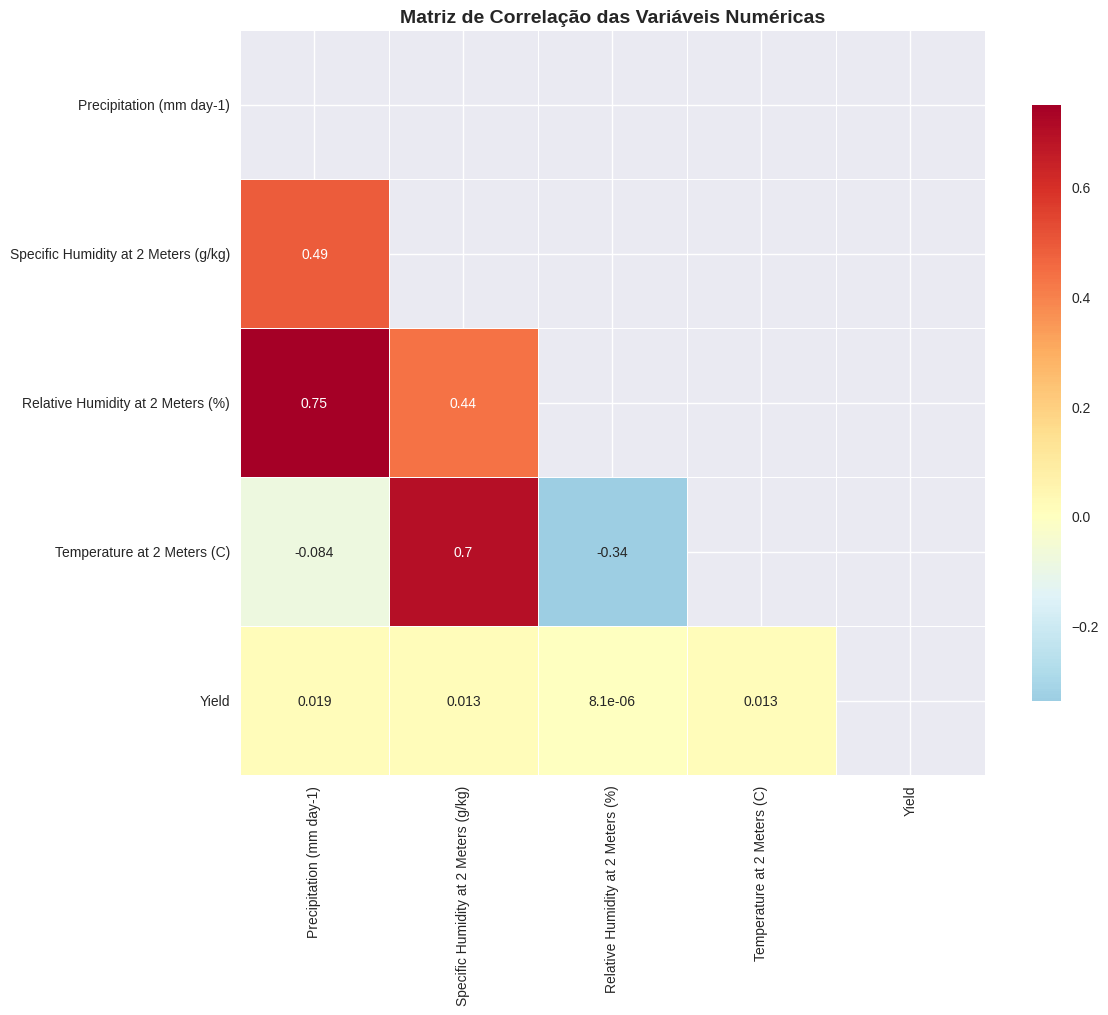

🔍 Principais correlações com o Rendimento:
  Precipitation (mm day-1): 0.019
  Temperature at 2 Meters (C): 0.013
  Specific Humidity at 2 Meters (g/kg): 0.013
  Relative Humidity at 2 Meters (%): 0.000


In [27]:
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("🔍 Principais correlações com o Rendimento:")
yield_correlations = correlation_matrix['Yield'].sort_values(key=abs, ascending=False)
for var, corr in yield_correlations.items():
    if var != 'Yield':
        print(f"  {var}: {corr:.3f}")

### Principais Insights da Análise Exploratória:

1. **Distribuição dos dados:** [Descreva aqui as principais observações sobre as distribuições]
2. **Correlações:** [Destaque as correlações mais significativas encontradas]
3. **Diferenças entre culturas:** [Comente sobre as diferenças de rendimento entre as culturas]
4. **Qualidade dos dados:** [Avalie a presença de outliers, valores ausentes, etc.]

## 3. Machine Learning Não Supervisionado

Utilizaremos técnicas de clusterização para identificar padrões nos dados e detecção de outliers para encontrar cenários discrepantes.

In [28]:
features_for_clustering = ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 
                          'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)']

X_cluster = df[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("✅ Dados preparados para clusterização (normalizados)")
print(f"Shape dos dados: {X_scaled.shape}")

✅ Dados preparados para clusterização (normalizados)
Shape dos dados: (156, 4)


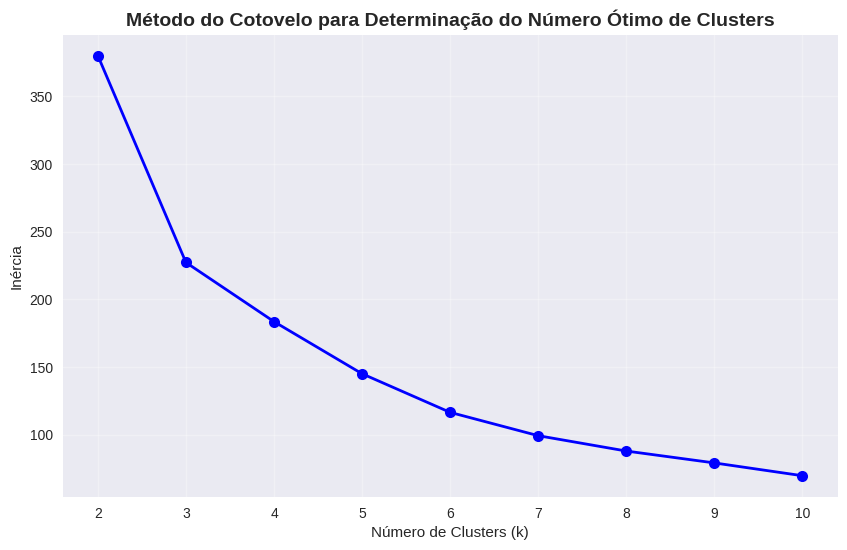

🎯 Número ótimo de clusters escolhido: 4


In [29]:
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método do Cotovelo para Determinação do Número Ótimo de Clusters', 
          fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True, alpha=0.3)
plt.show()

optimal_k = 4
print(f"🎯 Número ótimo de clusters escolhido: {optimal_k}")

In [30]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters

print("📊 Distribuição dos clusters:")
print(df['Cluster'].value_counts().sort_index())

print("\n🌾 Distribuição das culturas por cluster:")
cluster_crop_distribution = pd.crosstab(df['Cluster'], df['Crop'])
print(cluster_crop_distribution)

📊 Distribuição dos clusters:
Cluster
0    12
1    68
2    36
3    40
Name: count, dtype: int64

🌾 Distribuição das culturas por cluster:
Crop     Cocoa, beans  Oil palm fruit  Rice, paddy  Rubber, natural
Cluster                                                            
0                   3               3            3                3
1                  17              17           17               17
2                   9               9            9                9
3                  10              10           10               10


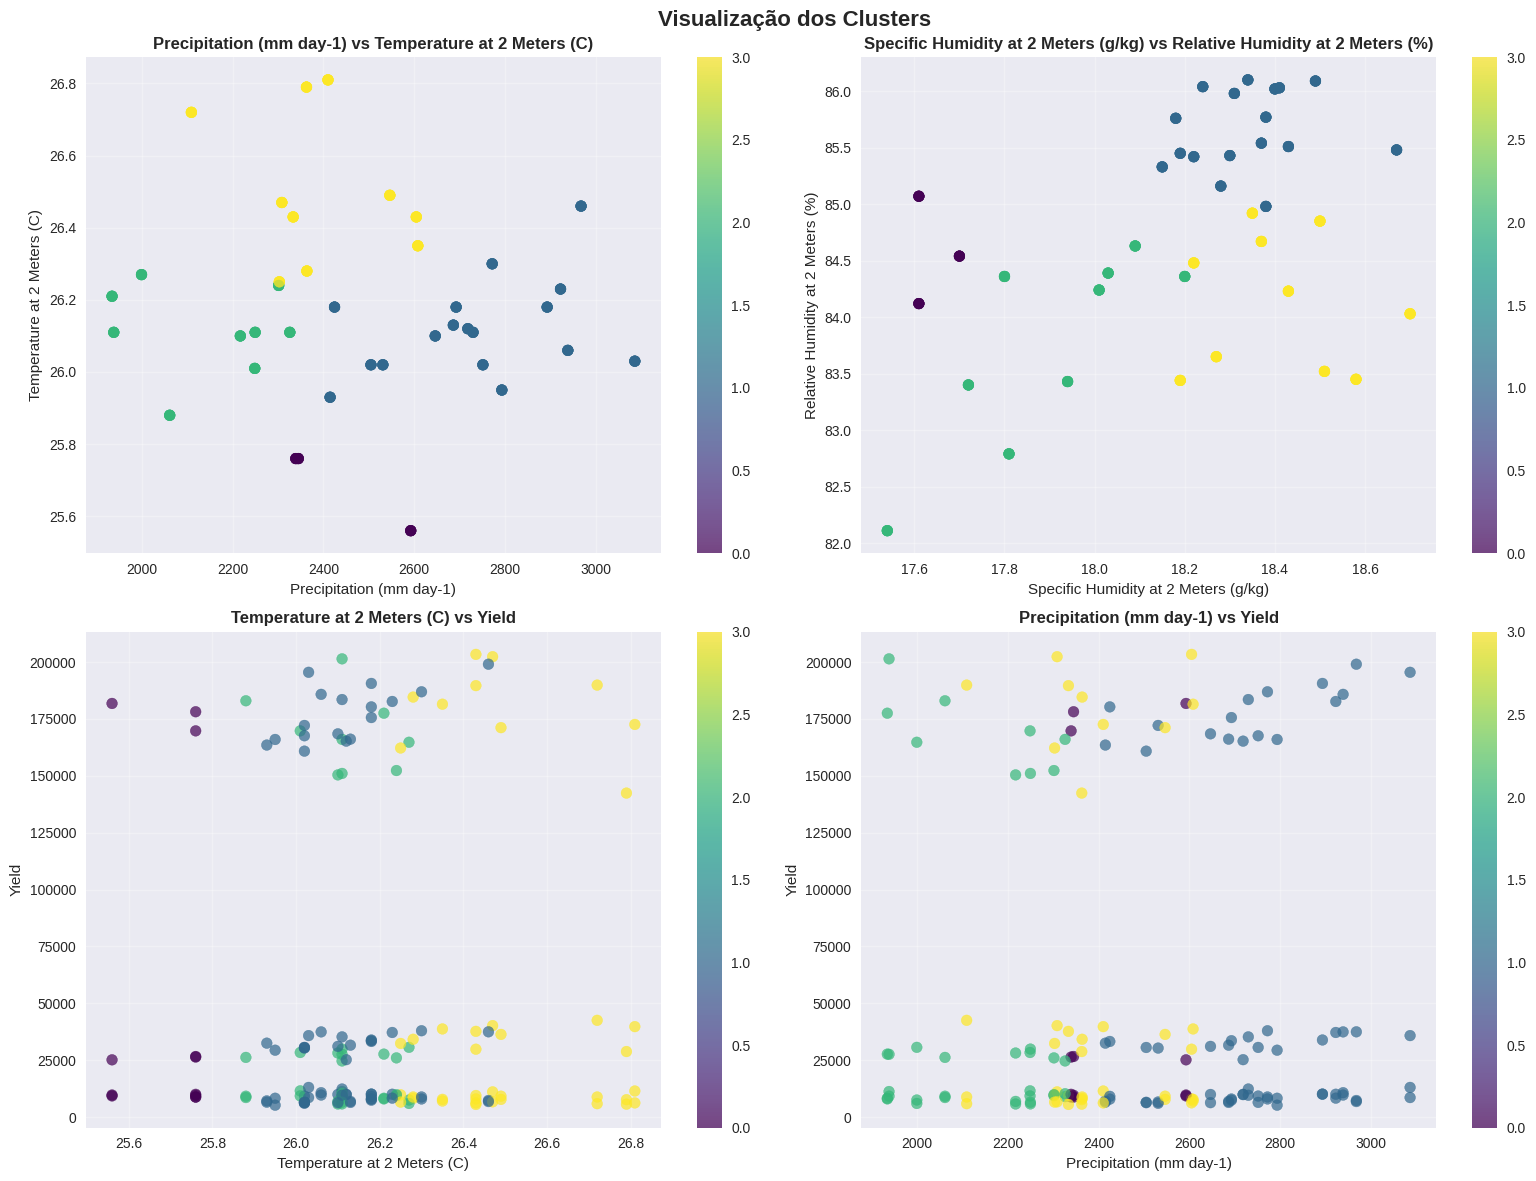

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Visualização dos Clusters', fontsize=16, fontweight='bold')

feature_pairs = [('Precipitation (mm day-1)', 'Temperature at 2 Meters (C)'),
                ('Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)'),
                ('Temperature at 2 Meters (C)', 'Yield'),
                ('Precipitation (mm day-1)', 'Yield')]

for i, (x_var, y_var) in enumerate(feature_pairs):
    row = i // 2
    col = i % 2
    
    scatter = axes[row, col].scatter(df[x_var], df[y_var], c=df['Cluster'], 
                                    cmap='viridis', alpha=0.7, s=60)
    axes[row, col].set_xlabel(x_var)
    axes[row, col].set_ylabel(y_var)
    axes[row, col].set_title(f'{x_var} vs {y_var}', fontweight='bold')
    axes[row, col].grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=axes[row, col])

plt.tight_layout()
plt.show()

In [32]:
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = isolation_forest.fit_predict(X_scaled)

df['Outlier'] = outliers
df['Is_Outlier'] = df['Outlier'] == -1

outlier_count = sum(df['Is_Outlier'])
print("🚨 Outliers detectados: {outlier_count} ({outlier_count/len(df)*100:.1f}% dos dados)")

print("\n📋 Distribuição de outliers por cultura:")
outlier_by_crop = df.groupby('Crop')['Is_Outlier'].sum()
for crop, count in outlier_by_crop.items():
    total_crop = len(df[df['Crop'] == crop])
    percentage = count/total_crop*100
    print(f"  {crop}: {count}/{total_crop} ({percentage:.1f}%)")

🚨 Outliers detectados: 16 (10.3% dos dados)

📋 Distribuição de outliers por cultura:
  Cocoa, beans: 4/39 (10.3%)
  Oil palm fruit: 4/39 (10.3%)
  Rice, paddy: 4/39 (10.3%)
  Rubber, natural: 4/39 (10.3%)


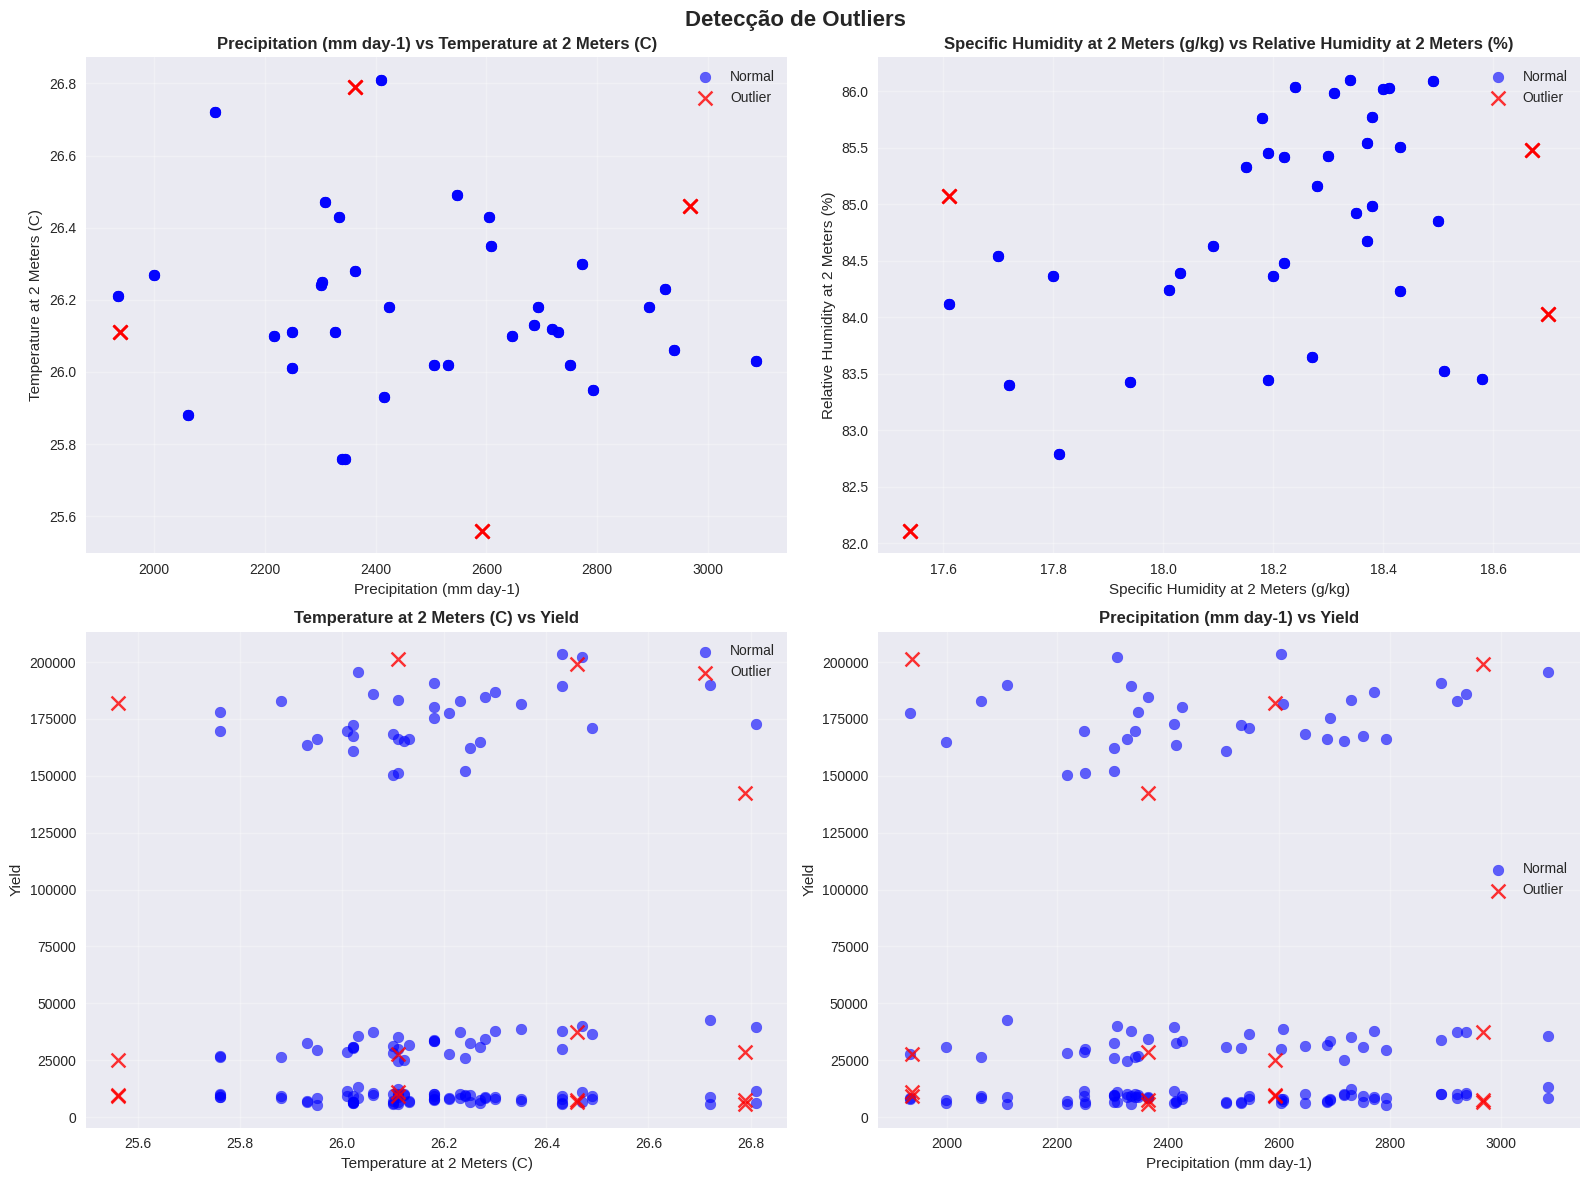

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detecção de Outliers', fontsize=16, fontweight='bold')

for i, (x_var, y_var) in enumerate(feature_pairs):
    row = i // 2
    col = i % 2
    
    normal_data = df[df['Is_Outlier'] == False]
    outlier_data = df[df['Is_Outlier'] == True]
    
    axes[row, col].scatter(normal_data[x_var], normal_data[y_var], 
                          c='blue', alpha=0.6, s=60, label='Normal')
    axes[row, col].scatter(outlier_data[x_var], outlier_data[y_var], 
                          c='red', alpha=0.8, s=100, marker='x', label='Outlier')
    
    axes[row, col].set_xlabel(x_var)
    axes[row, col].set_ylabel(y_var)
    axes[row, col].set_title(f'{x_var} vs {y_var}', fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análise dos Resultados de Clusterização:

1. **Clusters identificados:** [Descreva os padrões encontrados em cada cluster]
2. **Outliers detectados:** [Analise os outliers encontrados e suas possíveis causas]
3. **Relação com as culturas:** [Comente sobre como as culturas se distribuem nos clusters]
4. **Insights para agricultura:** [Explique como esses padrões podem ajudar na agricultura]

## 4. Machine Learning Supervisionado

Agora vamos desenvolver modelos preditivos para prever o rendimento das safras com base nas condições ambientais.

In [34]:
label_encoder = LabelEncoder()
df['Crop_Encoded'] = label_encoder.fit_transform(df['Crop'])

features = ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 
           'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)', 'Crop_Encoded']
target = 'Yield'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

print(f"✅ Dados preparados para modelagem")
print(f"Features utilizadas: {features}")
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"\nMapeamento das culturas:")
for i, crop in enumerate(label_encoder.classes_):
    print(f"  {i}: {crop}")

✅ Dados preparados para modelagem
Features utilizadas: ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)', 'Crop_Encoded']
Tamanho do conjunto de treino: (124, 5)
Tamanho do conjunto de teste: (32, 5)

Mapeamento das culturas:
  0: Cocoa, beans
  1: Oil palm fruit
  2: Rice, paddy
  3: Rubber, natural


In [35]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

results = {}

print("🤖 Treinando modelos...\n")

for name, model in models.items():
    print(f"Treinando {name}...")
    
    if name in ['Support Vector Regression', 'Neural Network']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        X_cv = X_train_scaled
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        X_cv = X_train
    
    cv_scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='r2')
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'CV_R²_Mean': cv_scores.mean(),
        'CV_R²_Std': cv_scores.std(),
        'Predictions': y_pred
    }
    
    print(f"  ✅ {name} - R²: {r2:.3f}, RMSE: {rmse:.2f}")

print("\n🎯 Treinamento concluído!")

🤖 Treinando modelos...

Treinando Linear Regression...
  ✅ Linear Regression - R²: -0.101, RMSE: 65364.57
Treinando Random Forest...
  ✅ Random Forest - R²: 0.994, RMSE: 4640.26
Treinando Support Vector Regression...
  ✅ Support Vector Regression - R²: -0.311, RMSE: 71312.76
Treinando Gradient Boosting...
  ✅ Gradient Boosting - R²: 0.993, RMSE: 5180.67
Treinando Neural Network...
  ✅ Neural Network - R²: -0.173, RMSE: 67447.38

🎯 Treinamento concluído!


In [36]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(3)

print("📊 Comparação dos Modelos:")
print("=" * 80)
display_cols = ['MAE', 'RMSE', 'R²', 'CV_R²_Mean', 'CV_R²_Std']
print(results_df[display_cols].to_string())

best_model = results_df['R²'].idxmax()
print(f"\n🏆 Melhor modelo: {best_model} (R² = {results_df.loc[best_model, 'R²']:.3f})")

📊 Comparação dos Modelos:
                                    MAE          RMSE        R² CV_R²_Mean CV_R²_Std
Linear Regression          53724.485077  65364.569016 -0.101459  -0.027668  0.070361
Random Forest               2748.052188   4640.261954  0.994449   0.984766  0.010301
Support Vector Regression  38973.189936  71312.757911 -0.311046  -0.368727  0.246639
Gradient Boosting             3057.8072   5180.665253  0.993081   0.982241  0.007363
Neural Network             41392.769181   67447.37873 -0.172772  -0.191966  0.156835

🏆 Melhor modelo: Random Forest (R² = 0.994)


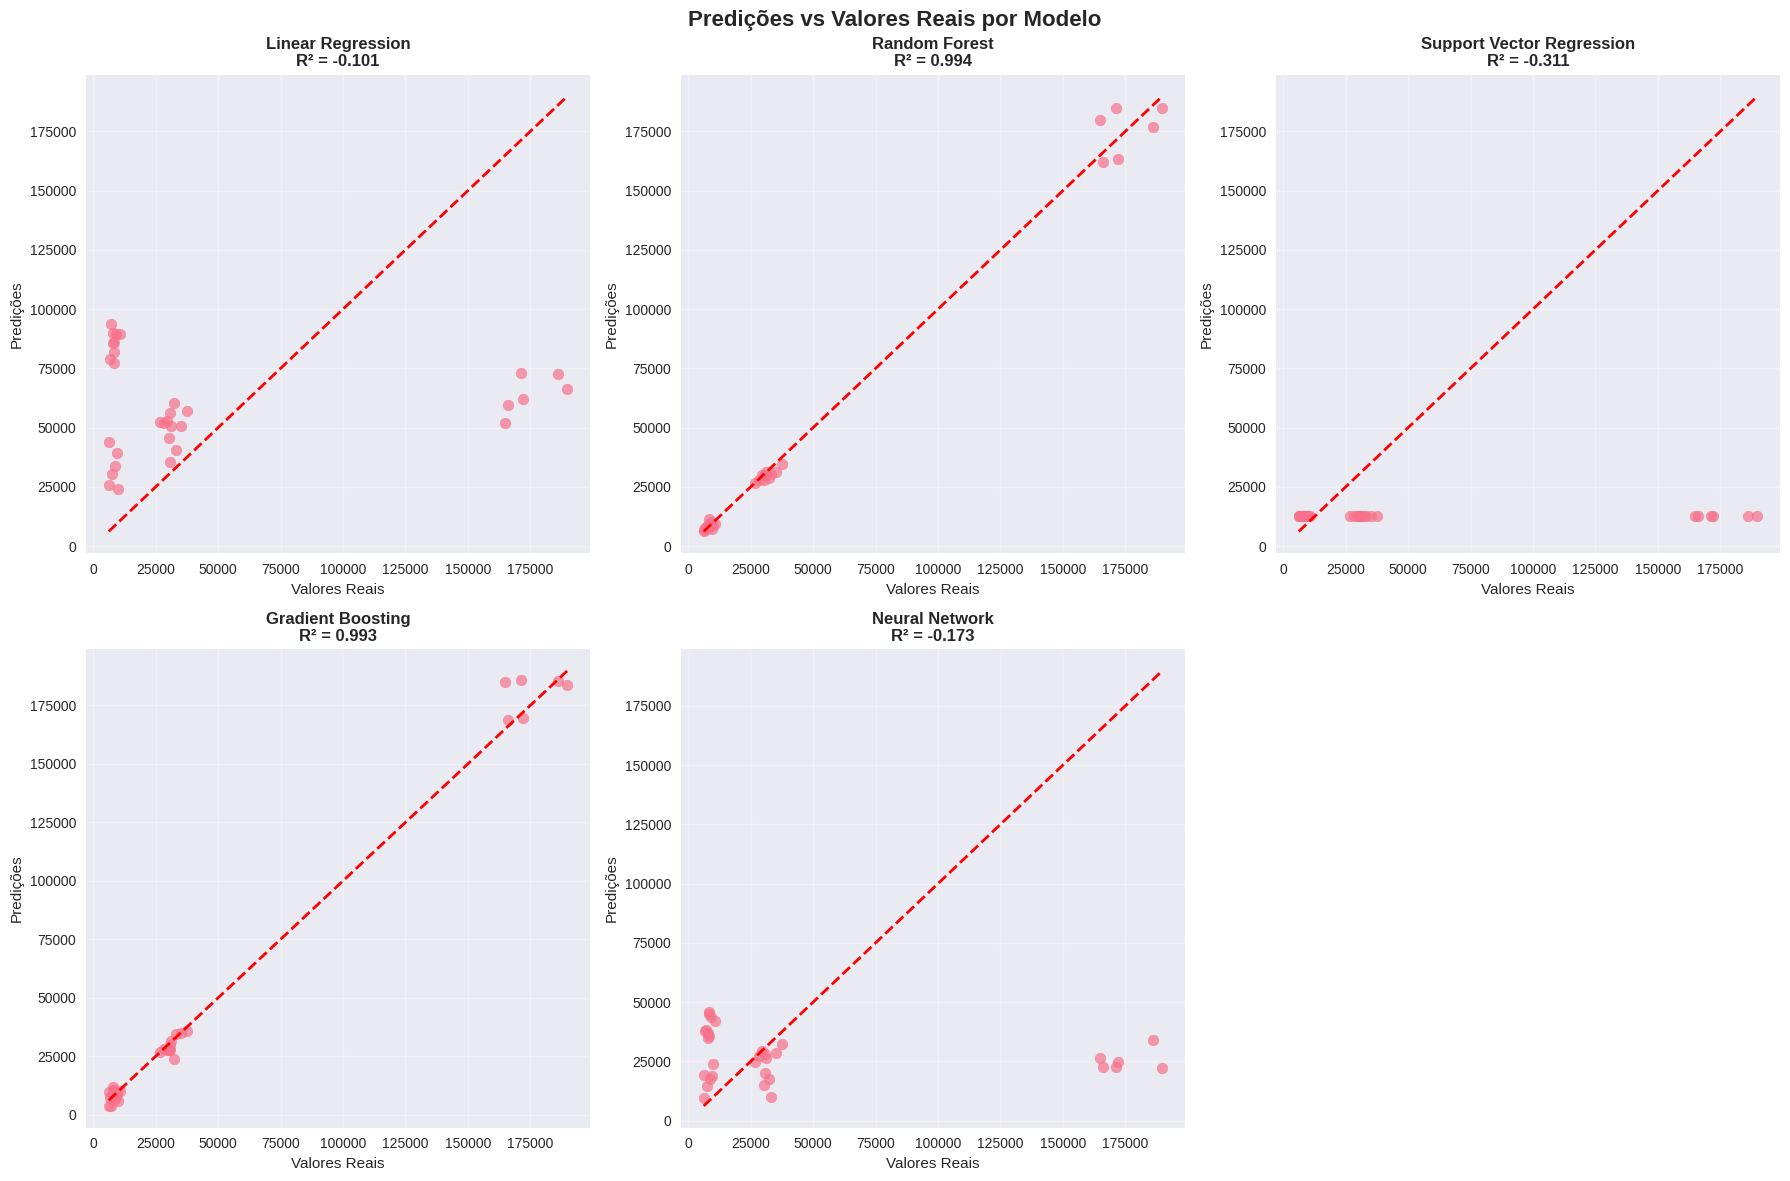

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Predições vs Valores Reais por Modelo', fontsize=16, fontweight='bold')

for i, (name, result) in enumerate(results.items()):
    row = i // 3
    col = i % 3
    
    axes[row, col].scatter(y_test, result['Predictions'], alpha=0.7, s=60)
    axes[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                       'r--', linewidth=2)
    axes[row, col].set_xlabel('Valores Reais')
    axes[row, col].set_ylabel('Predições')
    axes[row, col].set_title(f'{name}\nR² = {result["R²"]:.3f}', fontweight='bold')
    axes[row, col].grid(True, alpha=0.3)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

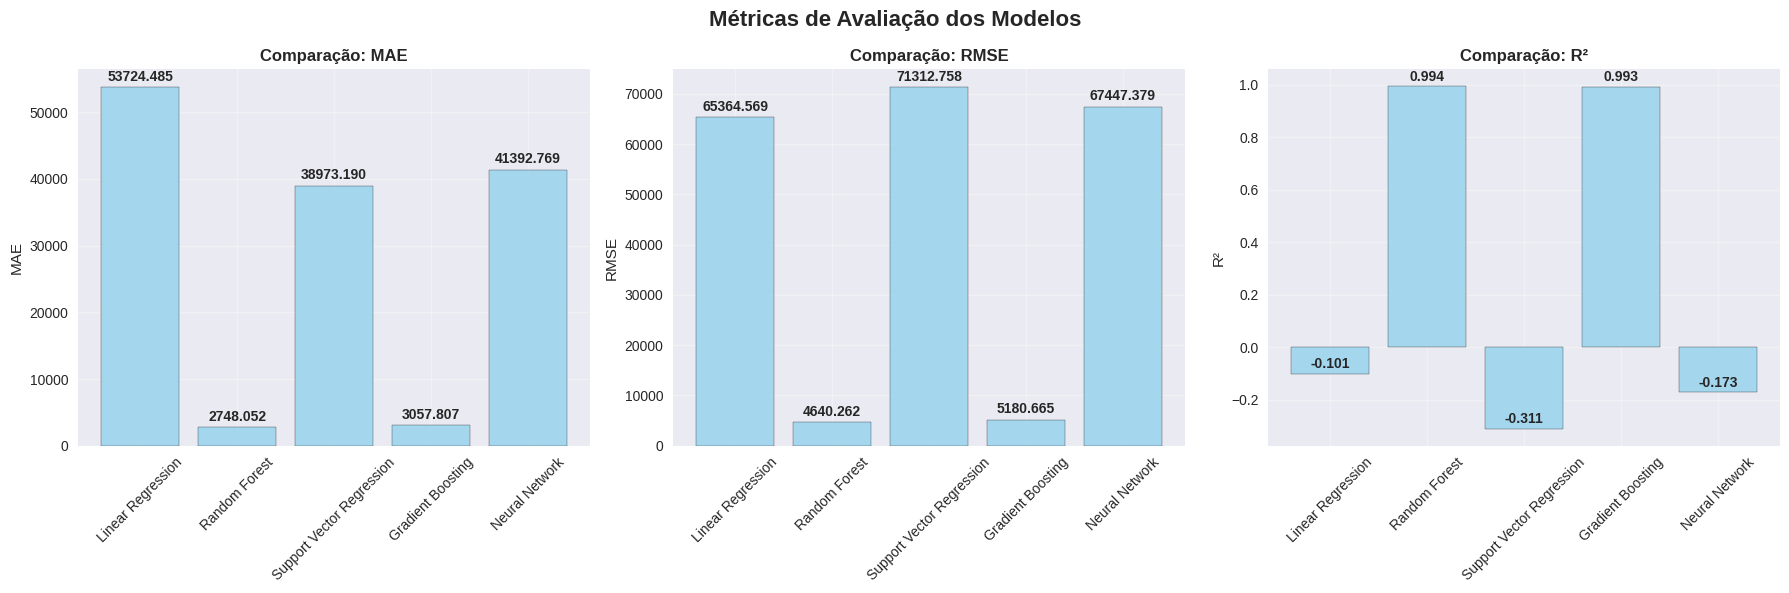

In [38]:
metrics = ['MAE', 'RMSE', 'R²']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    model_names = list(results.keys())
    values = [results[model][metric] for model in model_names]
    
    bars = axes[i].bar(model_names, values, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Comparação: {metric}', fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Métricas de Avaliação dos Modelos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

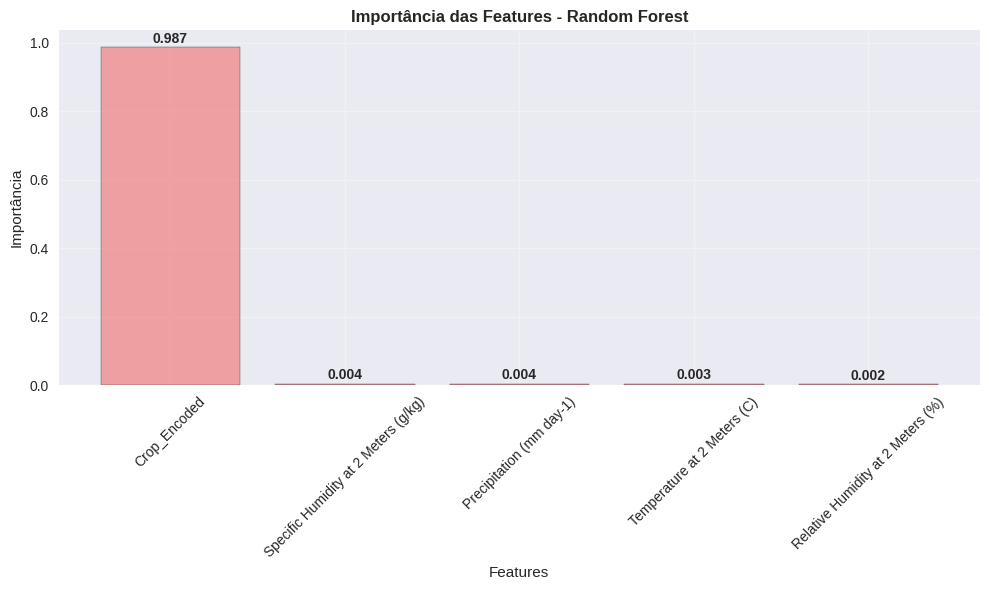

🔍 Ranking de Importância das Features:
  Crop_Encoded: 0.987
  Specific Humidity at 2 Meters (g/kg): 0.004
  Precipitation (mm day-1): 0.004
  Temperature at 2 Meters (C): 0.003
  Relative Humidity at 2 Meters (%): 0.002


In [39]:
best_model_name = results_df['R²'].idxmax()
best_model_obj = models[best_model_name]

if best_model_name == 'Random Forest':
    feature_importance = best_model_obj.feature_importances_
    feature_names = features
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(importance_df['Feature'], importance_df['Importance'], 
                   alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title(f'Importância das Features - {best_model_name}', fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importância')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, importance_df['Importance']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("🔍 Ranking de Importância das Features:")
    for i, row in importance_df.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.3f}")
else:
    print(f"⚠️ Análise de importância das features não disponível para {best_model_name}")

## 5. Análise e Conclusões

### Principais Resultados:

1. **Melhor Modelo:** [Descreva qual foi o melhor modelo e por quê]
2. **Performance:** [Analise as métricas obtidas]
3. **Features mais importantes:** [Comente sobre quais variáveis são mais relevantes]
4. **Limitações:** [Discuta as limitações do estudo]

### Pontos Fortes do Trabalho:
- Análise exploratória completa dos dados
- Aplicação de técnicas de clusterização para identificar padrões
- Detecção e análise de outliers
- Comparação de múltiplos algoritmos de Machine Learning
- Validação cruzada para robustez dos resultados
- Visualizações claras e informativas

### Limitações e Melhorias Futuras:
- Dataset relativamente pequeno (157 registros)
- Possibilidade de incluir mais variáveis ambientais
- Teste de técnicas de feature engineering
- Implementação de ensemble methods
- Coleta de dados temporais para análise de séries temporais

### Aplicações Práticas:
O modelo desenvolvido pode ser utilizado pela FarmTech Solutions para:
- Predição de rendimento de safras
- Otimização de condições de cultivo
- Planejamento agrícola
- Detecção de condições anômalas
- Suporte à tomada de decisões

In [40]:
print("🎯 RESUMO FINAL DOS RESULTADOS")
print("=" * 50)
print(f"📊 Dataset: {len(df)} registros, {len(df.columns)} variáveis")
print(f"🌾 Culturas analisadas: {len(df['Crop'].unique())}")
print(f"🔍 Clusters identificados: {optimal_k}")
print(f"🚨 Outliers detectados: {outlier_count} ({outlier_count/len(df)*100:.1f}%)")
print(f"🏆 Melhor modelo: {best_model_name}")
print(f"📈 Melhor R²: {results_df.loc[best_model_name, 'R²']:.3f}")
print(f"📉 Melhor RMSE: {results_df.loc[best_model_name, 'RMSE']:.2f}")
print("\n✅ Análise concluída com sucesso!")

🎯 RESUMO FINAL DOS RESULTADOS
📊 Dataset: 156 registros, 10 variáveis
🌾 Culturas analisadas: 4
🔍 Clusters identificados: 4
🚨 Outliers detectados: 16 (10.3%)
🏆 Melhor modelo: Random Forest
📈 Melhor R²: 0.994
📉 Melhor RMSE: 4640.26

✅ Análise concluída com sucesso!
